# 🗽 Coste medio por viaje por minuto y zona de taxis de New York

**Fuente:** [Datos de viajes del NYC Taxi & Limousine Commission (TLC)](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

**Descripción:** Este cuaderno analiza el coste medio por viaje según por minuto y la zona de los taxis de Nueva York, además de evaluar su coste computacional utilizando Apache Spark en un entorno distribuido.

## Configuración

In [1]:
import time
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, unix_timestamp, avg, to_timestamp, round

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

spark

In [2]:
spark.sparkContext.defaultParallelism

8

Mostrar configuración básica

In [3]:
print("Número de particiones por defecto:", spark.conf.get("spark.sql.shuffle.partitions"))

Número de particiones por defecto: 200


## Cargar de datos
Cargar los viajes en taxi con un ```dataframe``` y presentarlos por pantalla usando la librería Pandas

In [4]:
t0 = time.perf_counter()
df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("data")
print(f"Número total de viajes: {df.count():,}")

Carga y cache inicial: 0.66s
Número total de viajes: 41,169,720


In [5]:
df.select("*").limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-10-01 00:30:44,2024-10-01 00:48:26,1,3.00,1,N,162,246,1,18.4,1.0,0.5,1.50,0.0,1.0,24.90,2.5,0.0
1,1,2024-10-01 00:12:20,2024-10-01 00:25:25,1,2.20,1,N,48,236,1,14.2,3.5,0.5,3.80,0.0,1.0,23.00,2.5,0.0
2,1,2024-10-01 00:04:46,2024-10-01 00:13:52,1,2.70,1,N,142,24,1,13.5,3.5,0.5,3.70,0.0,1.0,22.20,2.5,0.0
3,1,2024-10-01 00:12:10,2024-10-01 00:23:01,1,3.10,1,N,233,75,1,14.2,3.5,0.5,2.00,0.0,1.0,21.20,2.5,0.0
4,1,2024-10-01 00:30:22,2024-10-01 00:30:39,1,0.00,1,N,262,262,3,3.0,3.5,0.5,0.00,0.0,1.0,8.00,2.5,0.0
5,2,2024-10-01 00:31:20,2024-10-01 00:36:00,2,0.97,1,N,137,137,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.0
6,1,2024-10-01 00:42:57,2024-10-01 00:49:01,1,1.30,1,N,142,48,1,7.9,3.5,0.5,2.55,0.0,1.0,15.45,2.5,0.0
7,1,2024-10-01 00:59:55,2024-10-01 01:02:24,1,0.50,1,N,230,161,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0
8,1,2024-10-01 00:00:47,2024-10-01 00:04:22,0,1.10,1,N,142,237,1,7.2,3.5,0.5,3.00,0.0,1.0,15.20,2.5,0.0
9,1,2024-10-01 00:17:36,2024-10-01 00:26:22,1,2.20,1,N,162,145,1,11.4,3.5,0.5,3.30,0.0,1.0,19.70,2.5,0.0


Cargar las los distritos y zonas donde Nueva York así como su designación num

In [6]:
zones = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
zones.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

## Análisis
Calcular la duración de los viajes apartir de la hora de recogida y llegada

In [7]:
df = (
    df.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
      .withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))
)

df = df.withColumn(
    "duration_hours",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 3600
)

Filtrar outliners, viajes de más de 5 horas, sin casi coste o duración cero.

In [8]:
df_valid = df.filter(
    (col("fare_amount") > 2.5) &              
    (col("trip_distance") > 0.1) &            
    (col("duration_hours") > 0.05) &          
    (col("duration_hours") < 5)            
)

Calcular el coste per hora por viaje grabado

In [9]:
df_valid = df_valid.withColumn(
    "cost_per_minute",
    col("total_amount") / (col("duration_hours") * 60)
)

Motrar el corte por hora:

In [10]:
df_valid.select("*").limit(10).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration_hours,cost_per_minute
0,2,2024-10-01 00:30:44,2024-10-01 00:48:26,1,3.00,1,N,162,246,1,...,1.0,0.5,1.50,0.0,1.0,24.90,2.5,0.0,0.295000,1.406780
1,1,2024-10-01 00:12:20,2024-10-01 00:25:25,1,2.20,1,N,48,236,1,...,3.5,0.5,3.80,0.0,1.0,23.00,2.5,0.0,0.218056,1.757962
2,1,2024-10-01 00:04:46,2024-10-01 00:13:52,1,2.70,1,N,142,24,1,...,3.5,0.5,3.70,0.0,1.0,22.20,2.5,0.0,0.151667,2.439560
3,1,2024-10-01 00:12:10,2024-10-01 00:23:01,1,3.10,1,N,233,75,1,...,3.5,0.5,2.00,0.0,1.0,21.20,2.5,0.0,0.180833,1.953917
4,2,2024-10-01 00:31:20,2024-10-01 00:36:00,2,0.97,1,N,137,137,1,...,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.0,0.077778,3.137143
5,1,2024-10-01 00:42:57,2024-10-01 00:49:01,1,1.30,1,N,142,48,1,...,3.5,0.5,2.55,0.0,1.0,15.45,2.5,0.0,0.101111,2.546703
6,1,2024-10-01 00:00:47,2024-10-01 00:04:22,0,1.10,1,N,142,237,1,...,3.5,0.5,3.00,0.0,1.0,15.20,2.5,0.0,0.059722,4.241860
7,1,2024-10-01 00:17:36,2024-10-01 00:26:22,1,2.20,1,N,162,145,1,...,3.5,0.5,3.30,0.0,1.0,19.70,2.5,0.0,0.146111,2.247148
8,1,2024-10-01 00:49:00,2024-10-01 00:52:20,1,0.60,1,N,229,162,1,...,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0,0.055556,3.630000
9,2,2024-10-01 00:07:26,2024-10-01 00:13:20,1,0.90,1,N,162,162,1,...,1.0,0.5,3.87,0.0,1.0,16.77,2.5,0.0,0.098333,2.842373


Combinar con la tablas de zonas y distritos por punto de recogida del pasajero: ``taxi_zone_lookup.csv```

In [11]:
df_joined = df_valid.join(
    zones,
    df_valid["PULocationID"] == zones["LocationID"],
    "left"
)

Calcular el coste media por minute agrupados por la zona de recogida:

In [12]:
avg_cost_per_zone = (
    df_joined.groupBy("Zone", "Borough")
    .agg(avg("cost_per_minute").alias("avg_cost_per_minute"))
    .orderBy(col("avg_cost_per_minute").desc())
)
t1 = time.perf_counter()
print(f"Tiempo de ejecución: {t1 - t0:.2f}s")

In [13]:
avg_cost_per_zone.show(20, truncate=False)

+--------------------------------+-------------+-------------------+
|Zone                            |Borough      |avg_cost_per_minute|
+--------------------------------+-------------+-------------------+
|Outside of NYC                  |N/A          |4.82277377271846   |
|Newark Airport                  |EWR          |4.461839165398534  |
|South Ozone Park                |Queens       |4.3009996450994965 |
|Randalls Island                 |Manhattan    |4.004120038675378  |
|Saint Michaels Cemetery/Woodside|Queens       |4.002197459673741  |
|Astoria Park                    |Queens       |3.968456164524256  |
|Kew Gardens                     |Queens       |3.640669699782429  |
|Elmhurst/Maspeth                |Queens       |3.4773556644960695 |
|Flushing Meadows-Corona Park    |Queens       |2.9995629006839795 |
|Highbridge Park                 |Manhattan    |2.9493116074507775 |
|Steinway                        |Queens       |2.7415592613076165 |
|Mariners Harbor                 |

## Visualización del corte promedio por minuto según zona de recogida

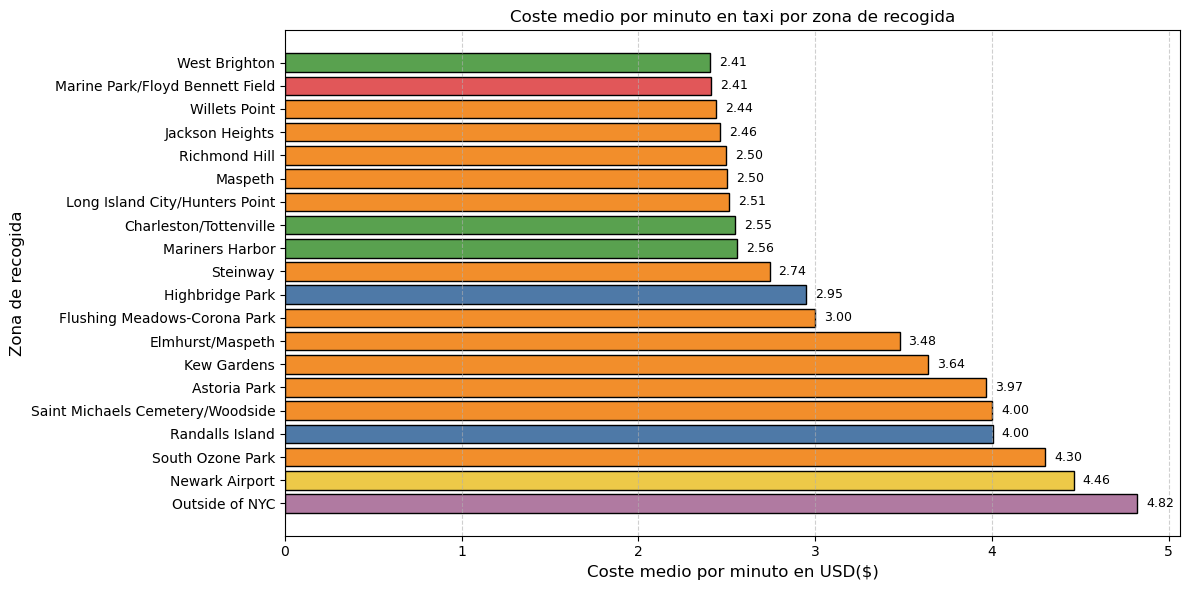

In [14]:
import matplotlib.pyplot as plt

zone_data = avg_cost_per_zone.collect()
top_zones = sorted(zone_data, key=lambda x: x["avg_cost_per_minute"], reverse=True)[:20]

x = [z["Zone"] for z in top_zones]
y = [z["avg_cost_per_minute"] for z in top_zones]
boroughs = [z["Borough"] for z in top_zones]

color_map = {
    "Manhattan": "#4E79A7",
    "Queens": "#F28E2B",
    "Brooklyn": "#E15759",
    "Bronx": "#76B7B2",
    "Staten Island": "#59A14F",
    "EWR": "#EDC948",
    "N/A": "#B07AA1"
}
colors = [color_map.get(b, "#9c9c9c") for b in boroughs]

plt.figure(figsize=(12, 6))
bars = plt.barh(x, y, color=colors, edgecolor='black')

plt.xlabel("Coste medio por minuto en USD($)", fontsize=12)
plt.ylabel("Zona de recogida", fontsize=12)
plt.title("Coste medio por minuto en taxi por zona de recogida")
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.05, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()
